In [1]:
#!pip install librosa
#!pip install pydub

# Step- 1 Converting .ogg to .wav

In [23]:
import os
import soundfile as sf

def oggtowav():
    folder_path = "/path/to/folder"

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".ogg"):
                ogg_file = os.path.join(root, file)
                wav_file = os.path.splitext(ogg_file)[0] + ".wav"
                data, samplerate = sf.read(ogg_file)
                sf.write(wav_file, data, samplerate)
                os.remove(ogg_file)

# Step -2 EDA

In [5]:
import matplotlib.pyplot as plt
import IPython.display as ipd #to display some of the graphs in the manner of a sound wave
import librosa #used for music and audio analysis
import librosa.display
%matplotlib inline

In [20]:
file_name = "Dataset/r2/S1/r2s1t1-02.wav"

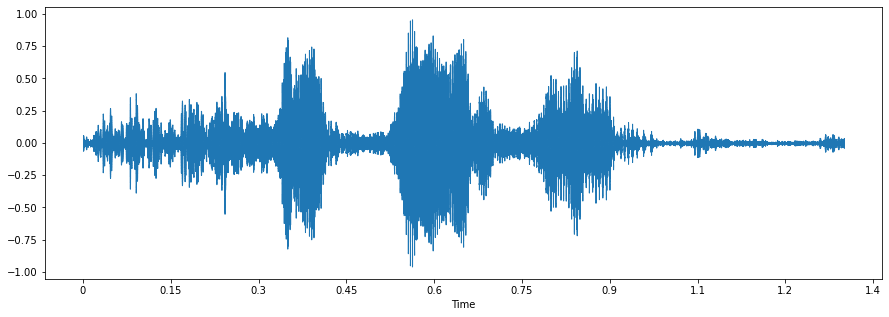

In [27]:
##Example: 
# Region- Baroda
# Speaker - 1
# Trial -1
# Item - 2

plt.figure(figsize=(15,5))
data, sample_rate = librosa.load(file_name)
librosa.display.waveshow(data,sr= sample_rate)
ipd.Audio(file_name)

In [24]:
sample_rate

22050

In [32]:
data # normalized values -1 to 1 

array([-0.05054819, -0.06030507, -0.05522265, ..., -0.03822208,
       -0.02886122,  0.        ], dtype=float32)

In [ ]:
# Note: Librosa will normalize all the sample rate and then it will give the normalized sample rate and convert into mono channel

In [29]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(file_name)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_9248/658351081.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wave_sample_rate, wave_audio = wav.read(file_name)


In [30]:
wave_sample_rate #actual sample rate

16000

In [31]:
wave_audio

array([-1753, -1875, -1942, ..., -1112, -1101, -1126], dtype=int16)

# Step-3 Generate Metadata

In [65]:
import os
import csv
import librosa

# set the base directory of the dataset
base_dir = 'Dataset/'

# define the regions and their corresponding class IDs and names
regions = {
    'r1': {'class_id': 1, 'class_name': 'saurashtra'},
    'r2': {'class_id': 2, 'class_name': 'baroda'},
    'r3': {'class_id': 3, 'class_name': 'south_gujarat'},
    'r4': {'class_id': 4, 'class_name': 'kutch'},
    'r5': {'class_id': 5, 'class_name': 'north_gujarat'}
}

# initialize the CSV data
csv_data = [['audio_file', 'start_time', 'end_time', 'silence', 'folder', 'class_id', 'class', 'region_id']]

# loop through the regions and their speakers and trials
for region, region_info in regions.items():
    for speaker in os.listdir(base_dir + region):
        for trial in os.listdir(base_dir + region + '/' + speaker):
            # check if the file has a suffix of -01 to -15
            if not any(trial.endswith('-{:02d}.wav'.format(i)) for i in range(1, 16)):
                continue
            audio_path = base_dir + region + '/' + speaker + '/' + trial

            # load the audio data using librosa
            y, sr = librosa.load(audio_path, sr=None, mono=True)
            sample_size = y.dtype.itemsize
            
            # split the audio into non-silent intervals
            intervals = librosa.effects.split(y, top_db=20)

            # loop through the intervals and calculate the start and end times and the silence duration
            for i in range(intervals.shape[0]):
                start_time_sec = intervals[i][0] / sr
                end_time_sec = intervals[i][1] / sr
                silence_sec = start_time_sec if i == 0 else start_time_sec - intervals[i-1][1] / sr

            # add the row to the CSV data
            csv_row = [trial, f"{start_time_sec:.3f}", f"{end_time_sec:.3f}", f"{silence_sec:.3f}", speaker, region_info['class_id'], region_info['class_name'], region]
            csv_data.append(csv_row)
        # append the new data to the existing metadata file
    metadata_file = 'metadata.csv'
    with open(metadata_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(csv_data)

# Step-4 Metadata EDA

In [1]:
import pandas as pd
metadata = pd.read_csv('metadata.csv')
metadata.head()

,audio_file,start_time,end_time,silence,folder,class_id,class,region_id
0,r1s1t1-01.wav,0.448,0.832,0.128,S1,1,saurashtra,r1
1,r1s1t1-02.wav,0.032,1.056,0.032,S1,1,saurashtra,r1
2,r1s1t1-03.wav,0.064,0.736,0.064,S1,1,saurashtra,r1
3,r1s1t1-04.wav,0.544,0.864,0.064,S1,1,saurashtra,r1
4,r1s1t1-05.wav,0.128,0.576,0.128,S1,1,saurashtra,r1


In [2]:
## check whether the dataset is imabalanced or not
metadata['class'].value_counts()

saurashtra       555
north_gujarat    375
south_gujarat    300
baroda           255
kutch            255
Name: class, dtype: int64

# Step- 5 Audio Data Preprocessing

In [3]:
import librosa
audio_file_path = "Dataset/r2/S5/r2s5t1-02.wav"
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [4]:
print(librosa_audio_data)

[-2.6679350e-05 -2.6097792e-05 -4.3342952e-05 ...  3.2900348e-02
  2.9778397e-02  1.3927685e-02]


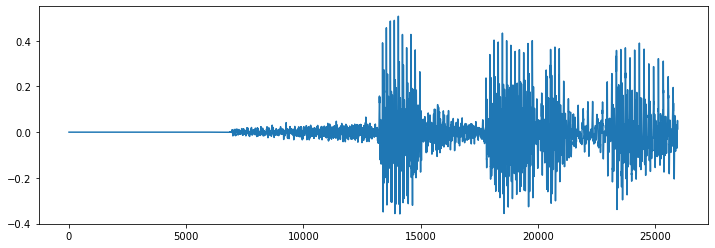

In [5]:
##plotting the librosa audio data
import matplotlib.pyplot as plt
#original audio with one channel
plt.figure(figsize=(12,4))
plt.plot(librosa_audio_data)

In [6]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [7]:
wave_audio

array([  -1,   -1,   -1, ..., 1234, 1061,  842], dtype=int16)

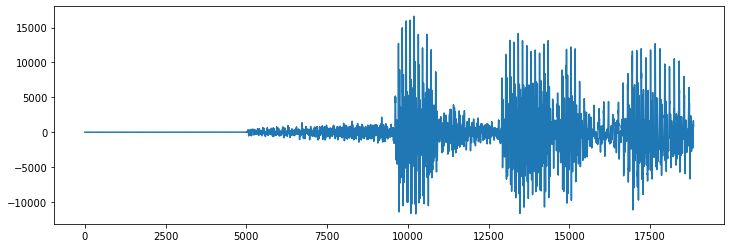

In [8]:
##plotting the original audio data (without normalizing)
import matplotlib.pyplot as plt
#original audio with 2 channels
plt.figure(figsize=(12,4))
plt.plot(wave_audio)

# Step - 6 Extract Features

We will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution accross the window size, so it is possible to analyse both the frequency and the time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [9]:
import librosa
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr= librosa_sample_rate)
print(mfccs.shape)

(20, 51)


In [10]:
## Extracting MFCC's for every audio file
import pandas as pd
import os
import librosa

audio_dataset_path ="Dataset/"
metadata = pd.read_csv('metadata.csv')
metadata.head()

,audio_file,start_time,end_time,silence,folder,class_id,class,region_id
0,r1s1t1-01.wav,0.448,0.832,0.128,S1,1,saurashtra,r1
1,r1s1t1-02.wav,0.032,1.056,0.032,S1,1,saurashtra,r1
2,r1s1t1-03.wav,0.064,0.736,0.064,S1,1,saurashtra,r1
3,r1s1t1-04.wav,0.544,0.864,0.064,S1,1,saurashtra,r1
4,r1s1t1-05.wav,0.128,0.576,0.128,S1,1,saurashtra,r1


In [11]:
def feature_extractor(file):
    audio, sample_rate= librosa.load(file, res_type='kaiser_fast')
    mfccs_Features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc = 40)
    mfccs_scaled_features = np.mean(mfccs_Features.T, axis=0)
    return mfccs_scaled_features

In [12]:
#!pip install resampy

In [13]:
import numpy as np
from tqdm import tqdm
extracted_features=[]
for i, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row['region_id'])+'/',str(row['folder'])+'/'+str(row['audio_file']))
    final_class_labels = row["class"]
    data = feature_extractor(file_name)
    extracted_features.append([data, final_class_labels])

1740it [00:36, 47.35it/s]


In [14]:
## converting extarcted_features to pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-374.6255, 146.65042, -9.395678, 8.122308, -8...",saurashtra
1,"[-363.12158, 149.59868, -26.211906, 15.929322,...",saurashtra
2,"[-388.23605, 138.35974, -27.35761, 35.835777, ...",saurashtra
3,"[-401.31366, 148.83533, -21.19773, 10.110929, ...",saurashtra
4,"[-350.158, 134.74763, -34.570965, 8.394304, -4...",saurashtra


In [15]:
#splot the datset into independent and dependent datset
x= np.array(extracted_features_df['feature'].tolist())
y= np.array(extracted_features_df['class'].tolist())


In [16]:
x.shape

(1740, 40)

In [17]:
## Label Encoding
#from sklearn.preprocessing import LabelEncoder
#label_encoder = LabelEncoder()
y= np.array(pd.get_dummies(y))

In [18]:
y.shape

(1740, 5)

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2, random_state=2)

In [20]:
x_train

array([[ -42.444103 ,  170.67075  ,  -31.178795 , ...,   -1.1346145,
          -3.5381405,    1.4523197],
       [-327.6864   ,  160.5368   ,   -6.583945 , ...,    6.1170063,
           1.4665476,   -3.0158124],
       [-203.80544  ,  150.61287  ,   10.158514 , ...,    1.5463676,
          -1.2114326,   -1.0844865],
       ...,
       [-237.97662  ,  161.69522  ,   -9.0605135, ...,   -2.1257536,
          -3.7182395,   -3.1009922],
       [-310.46866  ,  161.04453  ,  -22.314075 , ...,   -6.7118144,
          -4.081234 ,   -2.9656663],
       [-259.68668  ,  180.11072  ,  -52.107327 , ...,   -2.3164656,
          -1.8896844,   -2.1364334]], dtype=float32)

In [21]:
y

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [22]:
x_train.shape

(1392, 40)

In [23]:
y_train.shape

(1392, 5)

In [24]:
x_test.shape

(348, 40)

In [25]:
y_test.shape

(348, 5)

# Step-7 Model Creation

In [26]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [45]:
### No of classes
num_labels=y.shape[1]
num_labels

5

In [46]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(2000))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               4100      
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              202000    
_________________________________________________________________
activation_5 (Activation)    (None, 2000)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)              

In [48]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [49]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 1000
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/1000
44/44 [==============================] - 1s 6ms/step - loss: 7.7671 - accuracy: 0.2651 - val_loss: 1.6074 - val_accuracy: 0.3161

Epoch 00001: val_loss improved from inf to 1.60738, saving model to saved_models\audio_classification.hdf5
Epoch 2/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.6230 - accuracy: 0.3125 - val_loss: 1.5960 - val_accuracy: 0.3161

Epoch 00002: val_loss improved from 1.60738 to 1.59600, saving model to saved_models\audio_classification.hdf5
Epoch 3/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.5902 - accuracy: 0.3182 - val_loss: 1.5638 - val_accuracy: 0.3161

Epoch 00003: val_loss improved from 1.59600 to 1.56384, saving model to saved_models\audio_classification.hdf5
Epoch 4/1000
44/44 [==============================] - 0s 5ms/step - loss: 1.5793 - accuracy: 0.3182 - val_loss: 1.5577 - val_accuracy: 0.3161

Epoch 00004: val_loss improved from 1.56384 to 1.55772, saving model to saved_models\audio_classifi

44/44 [==============================] - 0s 6ms/step - loss: 1.5125 - accuracy: 0.3197 - val_loss: 1.5205 - val_accuracy: 0.3161

Epoch 00036: val_loss did not improve from 1.51510
Epoch 37/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5106 - accuracy: 0.3197 - val_loss: 1.5149 - val_accuracy: 0.3161

Epoch 00037: val_loss improved from 1.51510 to 1.51492, saving model to saved_models\audio_classification.hdf5
Epoch 38/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5125 - accuracy: 0.3197 - val_loss: 1.5151 - val_accuracy: 0.3161

Epoch 00038: val_loss did not improve from 1.51492
Epoch 39/1000
44/44 [==============================] - 0s 7ms/step - loss: 1.5098 - accuracy: 0.3197 - val_loss: 1.5152 - val_accuracy: 0.3161

Epoch 00039: val_loss did not improve from 1.51492
Epoch 40/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5116 - accuracy: 0.3197 - val_loss: 1.5148 - val_accuracy: 0.3161

Epoch 00040: val_loss improved

44/44 [==============================] - 0s 6ms/step - loss: 1.5095 - accuracy: 0.3197 - val_loss: 1.5149 - val_accuracy: 0.3161

Epoch 00077: val_loss did not improve from 1.51442
Epoch 78/1000
44/44 [==============================] - 0s 7ms/step - loss: 1.5107 - accuracy: 0.3197 - val_loss: 1.5148 - val_accuracy: 0.3161

Epoch 00078: val_loss did not improve from 1.51442
Epoch 79/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5199 - accuracy: 0.3197 - val_loss: 1.5149 - val_accuracy: 0.3161

Epoch 00079: val_loss did not improve from 1.51442
Epoch 80/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5195 - accuracy: 0.3197 - val_loss: 1.5148 - val_accuracy: 0.3161

Epoch 00080: val_loss did not improve from 1.51442
Epoch 81/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5165 - accuracy: 0.3190 - val_loss: 1.5148 - val_accuracy: 0.3161

Epoch 00081: val_loss did not improve from 1.51442
Epoch 82/1000
44/44 [==================

44/44 [==============================] - 0s 5ms/step - loss: 1.5093 - accuracy: 0.3197 - val_loss: 1.5149 - val_accuracy: 0.3161

Epoch 00119: val_loss did not improve from 1.51442
Epoch 120/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.5092 - accuracy: 0.3197 - val_loss: 1.5148 - val_accuracy: 0.3161

Epoch 00120: val_loss did not improve from 1.51442
Epoch 121/1000
44/44 [==============================] - 0s 5ms/step - loss: 1.5135 - accuracy: 0.3197 - val_loss: 1.5148 - val_accuracy: 0.3161

Epoch 00121: val_loss did not improve from 1.51442
Epoch 122/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5094 - accuracy: 0.3197 - val_loss: 1.5147 - val_accuracy: 0.3161

Epoch 00122: val_loss did not improve from 1.51442
Epoch 123/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5097 - accuracy: 0.3197 - val_loss: 1.5148 - val_accuracy: 0.3161

Epoch 00123: val_loss did not improve from 1.51442
Epoch 124/1000
44/44 [=============

44/44 [==============================] - 0s 6ms/step - loss: 1.5093 - accuracy: 0.3197 - val_loss: 1.5145 - val_accuracy: 0.3161

Epoch 00161: val_loss did not improve from 1.51442
Epoch 162/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5093 - accuracy: 0.3197 - val_loss: 1.5146 - val_accuracy: 0.3161

Epoch 00162: val_loss did not improve from 1.51442
Epoch 163/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5095 - accuracy: 0.3204 - val_loss: 1.5188 - val_accuracy: 0.3161

Epoch 00163: val_loss did not improve from 1.51442
Epoch 164/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5089 - accuracy: 0.3197 - val_loss: 1.5147 - val_accuracy: 0.3161

Epoch 00164: val_loss did not improve from 1.51442
Epoch 165/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5093 - accuracy: 0.3197 - val_loss: 1.5148 - val_accuracy: 0.3161

Epoch 00165: val_loss did not improve from 1.51442
Epoch 166/1000
44/44 [=============

44/44 [==============================] - 0s 4ms/step - loss: 1.5098 - accuracy: 0.3190 - val_loss: 1.5149 - val_accuracy: 0.3161

Epoch 00203: val_loss did not improve from 1.51442
Epoch 204/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.5111 - accuracy: 0.3197 - val_loss: 1.5150 - val_accuracy: 0.3161

Epoch 00204: val_loss did not improve from 1.51442
Epoch 205/1000
44/44 [==============================] - 0s 5ms/step - loss: 1.5102 - accuracy: 0.3197 - val_loss: 1.5150 - val_accuracy: 0.3161

Epoch 00205: val_loss did not improve from 1.51442
Epoch 206/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.5093 - accuracy: 0.3197 - val_loss: 1.5150 - val_accuracy: 0.3161

Epoch 00206: val_loss did not improve from 1.51442
Epoch 207/1000
44/44 [==============================] - 0s 3ms/step - loss: 1.5094 - accuracy: 0.3197 - val_loss: 1.5148 - val_accuracy: 0.3161

Epoch 00207: val_loss did not improve from 1.51442
Epoch 208/1000
44/44 [=============

44/44 [==============================] - 0s 4ms/step - loss: 1.5097 - accuracy: 0.3197 - val_loss: 1.5144 - val_accuracy: 0.3161

Epoch 00245: val_loss improved from 1.51442 to 1.51442, saving model to saved_models\audio_classification.hdf5
Epoch 246/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.5093 - accuracy: 0.3197 - val_loss: 1.5148 - val_accuracy: 0.3161

Epoch 00246: val_loss did not improve from 1.51442
Epoch 247/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.5092 - accuracy: 0.3197 - val_loss: 1.5148 - val_accuracy: 0.3161

Epoch 00247: val_loss did not improve from 1.51442
Epoch 248/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.5102 - accuracy: 0.3197 - val_loss: 1.5146 - val_accuracy: 0.3161

Epoch 00248: val_loss did not improve from 1.51442
Epoch 249/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.5095 - accuracy: 0.3197 - val_loss: 1.5147 - val_accuracy: 0.3161

Epoch 00249: val_loss did 

44/44 [==============================] - 0s 3ms/step - loss: 1.5254 - accuracy: 0.3197 - val_loss: 1.5034 - val_accuracy: 0.3161

Epoch 00326: val_loss improved from 1.50472 to 1.50341, saving model to saved_models\audio_classification.hdf5
Epoch 327/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.4972 - accuracy: 0.3197 - val_loss: 1.5011 - val_accuracy: 0.3161

Epoch 00327: val_loss improved from 1.50341 to 1.50108, saving model to saved_models\audio_classification.hdf5
Epoch 328/1000
44/44 [==============================] - 0s 3ms/step - loss: 1.4969 - accuracy: 0.3197 - val_loss: 1.5012 - val_accuracy: 0.3161

Epoch 00328: val_loss did not improve from 1.50108
Epoch 329/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.5442 - accuracy: 0.3197 - val_loss: 1.5077 - val_accuracy: 0.3161

Epoch 00329: val_loss did not improve from 1.50108
Epoch 330/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.5074 - accuracy: 0.3190 - val_los

44/44 [==============================] - 0s 5ms/step - loss: 1.4614 - accuracy: 0.3197 - val_loss: 1.4464 - val_accuracy: 0.3161

Epoch 00405: val_loss did not improve from 1.42577
Epoch 406/1000
44/44 [==============================] - 0s 3ms/step - loss: 1.4557 - accuracy: 0.3197 - val_loss: 1.4418 - val_accuracy: 0.3161

Epoch 00406: val_loss did not improve from 1.42577
Epoch 407/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.4536 - accuracy: 0.3197 - val_loss: 1.4440 - val_accuracy: 0.3161

Epoch 00407: val_loss did not improve from 1.42577
Epoch 408/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.4680 - accuracy: 0.3197 - val_loss: 1.4551 - val_accuracy: 0.3161

Epoch 00408: val_loss did not improve from 1.42577
Epoch 409/1000
44/44 [==============================] - 0s 5ms/step - loss: 1.4559 - accuracy: 0.3190 - val_loss: 1.4742 - val_accuracy: 0.3161

Epoch 00409: val_loss did not improve from 1.42577
Epoch 410/1000
44/44 [=============


Epoch 00444: val_loss did not improve from 1.39947
Epoch 445/1000
44/44 [==============================] - 0s 5ms/step - loss: 1.4389 - accuracy: 0.3190 - val_loss: 1.4404 - val_accuracy: 0.3161

Epoch 00445: val_loss did not improve from 1.39947
Epoch 446/1000
44/44 [==============================] - 0s 3ms/step - loss: 1.4378 - accuracy: 0.3197 - val_loss: 1.4167 - val_accuracy: 0.3161

Epoch 00446: val_loss did not improve from 1.39947
Epoch 447/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.4221 - accuracy: 0.3197 - val_loss: 1.3982 - val_accuracy: 0.3161

Epoch 00447: val_loss improved from 1.39947 to 1.39816, saving model to saved_models\audio_classification.hdf5
Epoch 448/1000
44/44 [==============================] - 0s 5ms/step - loss: 1.4205 - accuracy: 0.3197 - val_loss: 1.4008 - val_accuracy: 0.3161

Epoch 00448: val_loss did not improve from 1.39816
Epoch 449/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.4348 - accuracy: 0.3197 - 


Epoch 00525: val_loss did not improve from 1.36806
Epoch 526/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.4046 - accuracy: 0.3420 - val_loss: 1.3874 - val_accuracy: 0.3879

Epoch 00526: val_loss did not improve from 1.36806
Epoch 527/1000
44/44 [==============================] - 0s 3ms/step - loss: 1.4025 - accuracy: 0.3384 - val_loss: 1.3899 - val_accuracy: 0.3994

Epoch 00527: val_loss did not improve from 1.36806
Epoch 528/1000
44/44 [==============================] - 0s 5ms/step - loss: 1.4085 - accuracy: 0.3369 - val_loss: 1.3705 - val_accuracy: 0.3994

Epoch 00528: val_loss did not improve from 1.36806
Epoch 529/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.3933 - accuracy: 0.3455 - val_loss: 1.3606 - val_accuracy: 0.4080

Epoch 00529: val_loss improved from 1.36806 to 1.36061, saving model to saved_models\audio_classification.hdf5
Epoch 530/1000
44/44 [==============================] - 0s 6ms/step - loss: 1.3749 - accuracy: 0.3513 - 

44/44 [==============================] - 0s 4ms/step - loss: 1.1790 - accuracy: 0.4569 - val_loss: 1.1140 - val_accuracy: 0.5517

Epoch 00603: val_loss did not improve from 1.06788
Epoch 604/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.1796 - accuracy: 0.4540 - val_loss: 1.0639 - val_accuracy: 0.5489

Epoch 00604: val_loss improved from 1.06788 to 1.06386, saving model to saved_models\audio_classification.hdf5
Epoch 605/1000
44/44 [==============================] - 0s 5ms/step - loss: 1.1774 - accuracy: 0.4483 - val_loss: 1.0680 - val_accuracy: 0.5460

Epoch 00605: val_loss did not improve from 1.06386
Epoch 606/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.1991 - accuracy: 0.4504 - val_loss: 1.0688 - val_accuracy: 0.5632

Epoch 00606: val_loss did not improve from 1.06386
Epoch 607/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.1826 - accuracy: 0.4533 - val_loss: 1.0535 - val_accuracy: 0.5690

Epoch 00607: val_loss impr


Epoch 00641: val_loss improved from 0.95923 to 0.95360, saving model to saved_models\audio_classification.hdf5
Epoch 642/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.0832 - accuracy: 0.5086 - val_loss: 0.9644 - val_accuracy: 0.5977

Epoch 00642: val_loss did not improve from 0.95360
Epoch 643/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.0987 - accuracy: 0.5014 - val_loss: 0.9531 - val_accuracy: 0.6178

Epoch 00643: val_loss improved from 0.95360 to 0.95313, saving model to saved_models\audio_classification.hdf5
Epoch 644/1000
44/44 [==============================] - 0s 4ms/step - loss: 1.0545 - accuracy: 0.5108 - val_loss: 0.9937 - val_accuracy: 0.5862

Epoch 00644: val_loss did not improve from 0.95313
Epoch 645/1000
44/44 [==============================] - 0s 3ms/step - loss: 1.0648 - accuracy: 0.5122 - val_loss: 0.9328 - val_accuracy: 0.5948

Epoch 00645: val_loss improved from 0.95313 to 0.93284, saving model to saved_models\audio_clas


Epoch 00679: val_loss did not improve from 0.77178
Epoch 680/1000
44/44 [==============================] - 0s 4ms/step - loss: 0.9863 - accuracy: 0.5675 - val_loss: 0.9029 - val_accuracy: 0.7557

Epoch 00680: val_loss did not improve from 0.77178
Epoch 681/1000
44/44 [==============================] - 0s 4ms/step - loss: 0.9894 - accuracy: 0.5711 - val_loss: 0.8892 - val_accuracy: 0.6983

Epoch 00681: val_loss did not improve from 0.77178
Epoch 682/1000
44/44 [==============================] - 0s 6ms/step - loss: 0.9878 - accuracy: 0.5733 - val_loss: 0.7459 - val_accuracy: 0.7414

Epoch 00682: val_loss improved from 0.77178 to 0.74586, saving model to saved_models\audio_classification.hdf5
Epoch 683/1000
44/44 [==============================] - 0s 5ms/step - loss: 0.9903 - accuracy: 0.5453 - val_loss: 0.7760 - val_accuracy: 0.7213

Epoch 00683: val_loss did not improve from 0.74586
Epoch 684/1000
44/44 [==============================] - 0s 6ms/step - loss: 0.9784 - accuracy: 0.5776 - 

44/44 [==============================] - 0s 6ms/step - loss: 0.7555 - accuracy: 0.7155 - val_loss: 0.4517 - val_accuracy: 0.8764

Epoch 00758: val_loss did not improve from 0.44394
Epoch 759/1000
44/44 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.7601 - val_loss: 0.4821 - val_accuracy: 0.8764

Epoch 00759: val_loss did not improve from 0.44394
Epoch 760/1000
44/44 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.7371 - val_loss: 0.4828 - val_accuracy: 0.8822

Epoch 00760: val_loss did not improve from 0.44394
Epoch 761/1000
44/44 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.7529 - val_loss: 0.5148 - val_accuracy: 0.8506

Epoch 00761: val_loss did not improve from 0.44394
Epoch 762/1000
44/44 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.7550 - val_loss: 0.5193 - val_accuracy: 0.8477

Epoch 00762: val_loss did not improve from 0.44394
Epoch 763/1000
44/44 [=============

44/44 [==============================] - 0s 6ms/step - loss: 0.6605 - accuracy: 0.7687 - val_loss: 0.4104 - val_accuracy: 0.9023

Epoch 00798: val_loss did not improve from 0.38705
Epoch 799/1000
44/44 [==============================] - 0s 5ms/step - loss: 0.6380 - accuracy: 0.7744 - val_loss: 0.4031 - val_accuracy: 0.8966

Epoch 00799: val_loss did not improve from 0.38705
Epoch 800/1000
44/44 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.7701 - val_loss: 0.3778 - val_accuracy: 0.9109

Epoch 00800: val_loss improved from 0.38705 to 0.37782, saving model to saved_models\audio_classification.hdf5
Epoch 801/1000
44/44 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.7716 - val_loss: 0.4161 - val_accuracy: 0.8764

Epoch 00801: val_loss did not improve from 0.37782
Epoch 802/1000
44/44 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.7773 - val_loss: 0.4534 - val_accuracy: 0.8764

Epoch 00802: val_loss did 


Epoch 00838: val_loss did not improve from 0.36282
Epoch 839/1000
44/44 [==============================] - 0s 4ms/step - loss: 0.6041 - accuracy: 0.7895 - val_loss: 0.3838 - val_accuracy: 0.9023

Epoch 00839: val_loss did not improve from 0.36282
Epoch 840/1000
44/44 [==============================] - 0s 5ms/step - loss: 0.5561 - accuracy: 0.7974 - val_loss: 0.4275 - val_accuracy: 0.8879

Epoch 00840: val_loss did not improve from 0.36282
Epoch 841/1000
44/44 [==============================] - 0s 5ms/step - loss: 0.5689 - accuracy: 0.8053 - val_loss: 0.4057 - val_accuracy: 0.9023

Epoch 00841: val_loss did not improve from 0.36282
Epoch 842/1000
44/44 [==============================] - 0s 7ms/step - loss: 0.5332 - accuracy: 0.8168 - val_loss: 0.4464 - val_accuracy: 0.8994

Epoch 00842: val_loss did not improve from 0.36282
Epoch 843/1000
44/44 [==============================] - 0s 5ms/step - loss: 0.6045 - accuracy: 0.8003 - val_loss: 0.4635 - val_accuracy: 0.9109

Epoch 00843: val_lo


Epoch 00920: val_loss did not improve from 0.29416
Epoch 921/1000
44/44 [==============================] - 0s 5ms/step - loss: 0.5251 - accuracy: 0.8197 - val_loss: 0.3877 - val_accuracy: 0.9109

Epoch 00921: val_loss did not improve from 0.29416
Epoch 922/1000
44/44 [==============================] - 0s 4ms/step - loss: 0.5044 - accuracy: 0.8240 - val_loss: 0.3624 - val_accuracy: 0.9109

Epoch 00922: val_loss did not improve from 0.29416
Epoch 923/1000
44/44 [==============================] - 0s 4ms/step - loss: 0.4592 - accuracy: 0.8448 - val_loss: 0.3658 - val_accuracy: 0.9109

Epoch 00923: val_loss did not improve from 0.29416
Epoch 924/1000
44/44 [==============================] - 0s 4ms/step - loss: 0.5068 - accuracy: 0.8190 - val_loss: 0.3938 - val_accuracy: 0.9253

Epoch 00924: val_loss did not improve from 0.29416
Epoch 925/1000
44/44 [==============================] - 0s 4ms/step - loss: 0.5542 - accuracy: 0.8118 - val_loss: 0.4110 - val_accuracy: 0.9138

Epoch 00925: val_lo

44/44 [==============================] - 0s 5ms/step - loss: 0.5279 - accuracy: 0.8111 - val_loss: 0.4160 - val_accuracy: 0.9052

Epoch 00962: val_loss did not improve from 0.28002
Epoch 963/1000
44/44 [==============================] - 0s 5ms/step - loss: 0.5166 - accuracy: 0.8305 - val_loss: 0.3799 - val_accuracy: 0.9195

Epoch 00963: val_loss did not improve from 0.28002
Epoch 964/1000
44/44 [==============================] - 0s 5ms/step - loss: 0.4940 - accuracy: 0.8355 - val_loss: 0.3865 - val_accuracy: 0.9282

Epoch 00964: val_loss did not improve from 0.28002
Epoch 965/1000
44/44 [==============================] - 0s 4ms/step - loss: 0.4689 - accuracy: 0.8542 - val_loss: 0.4298 - val_accuracy: 0.9253

Epoch 00965: val_loss did not improve from 0.28002
Epoch 966/1000
44/44 [==============================] - 0s 6ms/step - loss: 0.4635 - accuracy: 0.8455 - val_loss: 0.4214 - val_accuracy: 0.9310

Epoch 00966: val_loss did not improve from 0.28002
Epoch 967/1000
44/44 [=============

In [50]:
test_accuracy=model.evaluate(x_test,y_test,verbose=0)
print(test_accuracy[1])

0.9166666865348816


In [65]:
import numpy as np
from sklearn.metrics import mean_squared_error , classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error

y_pred= model.predict(x_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display RMSE
print("Root Mean Squared Error (RMSE):", rmse)

# Additional evaluation measures
# Calculate and display other evaluation measures as desired
# For example, you can calculate and display mean absolute error (MAE) as follows:
mae = np.mean(np.abs(y_test - y_pred))
print("Mean Absolute Error (MAE):", mae)

# Precision
#precision = precision_score(y_test, y_pred)
#print("Precision:", precision)

# Recall
#recall = recall_score(y_test, y_pred)
#print("Recall:", recall)

# F1 Score
#f1 = f1_score(y_test, y_pred)
#print("F1 Score:", f1)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Root Mean Squared Error (RMSE): 0.17284594
Mean Absolute Error (MAE): 0.065978095
Mean Squared Error: 0.029875722


In [36]:
filename="Dataset/test.wav"
prediction_feature=feature_extractor(filename)
prediction_feature=prediction_feature.reshape(1,-1)
#prediction_feature
predict_x=model.predict(prediction_feature) 
classes_x=np.argmax(predict_x,axis=1)

In [37]:
classes_x

array([1], dtype=int64)

In [41]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Define a function to map samples to regions
def map_to_region(sample_index):
    if sample_index < num_samples_per_region:
        return 1
    elif sample_index < 2*num_samples_per_region:
        return 2
    elif sample_index < 3*num_samples_per_region:
        return 3
    elif sample_index < 4*num_samples_per_region:
        return 4
    elif sample_index < 5*num_samples_per_region:
        return 5
    else:
        return 0

# Normalize the feature vectors
prediction_feature = prediction_feature / np.linalg.norm(prediction_feature, axis=1, keepdims=True)
x_train_norm = x_train / np.linalg.norm(x_train, axis=1, keepdims=True)

# Calculate cosine similarity between the test feature vector and all feature vectors in the training set
similarity_scores = cosine_similarity(prediction_feature, x_train_norm)

# Map each sample in the training set to its corresponding region
num_samples_per_region = len(y_train) // 5
sample_regions = [map_to_region(i) for i in range(len(y_train))]

# Compute the average similarity score between the test file and all samples in each region
region_scores = [0, 0, 0, 0, 0]
region_counts = [0, 0, 0, 0, 0]
for i in range(len(similarity_scores[0])):
    region = sample_regions[i]
    region_scores[region-1] += similarity_scores[0][i]
    region_counts[region-1] += 1

# Assign the test file to the region with the highest average similarity score
region_rank = np.argsort(region_scores)[::-1]
predicted_region = region_rank[0] 
print("Test file belongs to region", predicted_region)


Test file belongs to region 4


In [42]:
region_rank

array([4, 2, 3, 0, 1], dtype=int64)

In [43]:
region_scores

[262.67133313417435,
 261.72021159529686,
 265.19083219766617,
 263.90780407190323,
 268.28130543231964]